[View in Colaboratory](https://colab.research.google.com/github/jarrydmartinx/SML-Notebooks/blob/master/dqn.ipynb)

# DQN

# Questions


*   How do I use Tensorboard from Colab
*  (Suraj) Is it best to distribute a subgraph which has internal dependencies but is parallelisable, or to give it to one GPU?
*   I've forgotten which this comma is here: e.g. (self.capacity,)
*   Why use lambda vs. list comprehension. I read list comprehension is a complete substitute, but with lambda i can reuse it right, whereas list comp I can't reuse? In light of the supposed equivalence of the two it blows my mind that we used a lambda inside a list comprehension :-*



In [0]:
! pip install -q dm-sonnet  # Sonnet not inc by default

## For OpenAI gym
# python-opengl not installed since we are not rendering anything
# Note: python-opengl maybe reqruired if we monitor to file - check this out: https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
# python-numpy not installed since a numpy package is already present
# Not sure about the others, need to isolate each package to see if they are all needed.
# cmake is definitely needed for the atari environment.
# ! apt-get -qq install python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev libboost-all-dev libsdl2-dev swig
! pip install -U -q gym
! pip install -U -q plotnine

In [3]:
import gym
import numpy as np
import sonnet as snt
import tensorflow as tf
import pandas as pd

import plotnine as gg
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Ingredients
1. make a neural net to approximate Q(s, a)
2. make a replay buffer (list basically, could use ring buffer etc.)
3. have a simple environment to debug with

In [0]:
class QNetwork(snt.AbstractModule):
  """A simple feedforward multi-layer-perceptron Q-function approximator.
  
  Q: State --> [vector of Q values, one for each action]
  
  Shapes:
  [batch_size, height, width] --> [batch_size, num_actions]
  

  """

  def __init__(self, hidden_sizes, num_actions):
    """Instantiate our kick-ass Q-network.
    
    Args:
      hidden_sizes: A list of integers, corresponding to the number of neurons
        in each of the hidden layers of the MLP.
      num_actions: Number of output actions.
    
    """
    super(QNetwork, self).__init__(name='q_network')
    # Calls constructor of superclass etc. Just ensures variables are shared,
    # once module is plugged into the graph.

    self._hidden_sizes = hidden_sizes
    self._num_actions = num_actions

  def _build(self, inputs):
    """Hooks the module into the TensorFlow graph.
    
    Args:
      inputs: A `tf.Tensor` of shape [batch_size, ...] and type tf.float32.
      
    Returns:
      A `tf.Tensor` of shape [num_actions] and type tf.float32 corresponding to
      [Q(s, a) for a in A]
    
    """
    # MLP expects a batch of vectors
    inputs = snt.BatchFlatten()(inputs)  # Flatten the input image into a vector
    
    # Inputs should be of size [batch_size, x]
    assert len(inputs.get_shape().as_list()) == 2  
   
    mlp = snt.nets.MLP(output_sizes=self._hidden_sizes + [self._num_actions])
    
    return mlp(inputs)

## Testing area

In [0]:
# Can make MLP as an exercise
class MyMLP():
  pass

  
  # layer_n = snt.Linear(output_size=blah)
  # tf.relu
  # etc

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[-0.24581951 -0.24164805  0.04359115 -0.42192426 -0.30897924]]


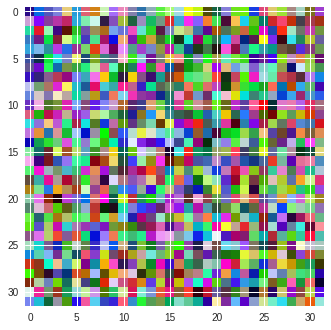

In [6]:
tf.reset_default_graph()

# Build our model
mlp = QNetwork(hidden_sizes=[30, 30], num_actions=5)  

# Create a tensor that generates random noise images
dummy_observation = tf.random_uniform(shape=(1, 32, 32, 3), dtype=tf.float32)

# Plug our model into this image and get 'q-values' out
q_values = mlp(dummy_observation)

with tf.train.MonitoredSession() as sess:
  q_val, dummy_val = sess.run([q_values, dummy_observation])
  plt.imshow(np.squeeze(dummy_val))
  print(q_val)

In [7]:
mlp.get_variables()

(<tf.Variable 'q_network/mlp/linear_0/w:0' shape=(3072, 30) dtype=float32_ref>,
 <tf.Variable 'q_network/mlp/linear_0/b:0' shape=(30,) dtype=float32_ref>,
 <tf.Variable 'q_network/mlp/linear_1/w:0' shape=(30, 30) dtype=float32_ref>,
 <tf.Variable 'q_network/mlp/linear_1/b:0' shape=(30,) dtype=float32_ref>,
 <tf.Variable 'q_network/mlp/linear_2/w:0' shape=(30, 5) dtype=float32_ref>,
 <tf.Variable 'q_network/mlp/linear_2/b:0' shape=(5,) dtype=float32_ref>)

In [8]:
tf.trainable_variables()

[<tf.Variable 'q_network/mlp/linear_0/w:0' shape=(3072, 30) dtype=float32_ref>,
 <tf.Variable 'q_network/mlp/linear_0/b:0' shape=(30,) dtype=float32_ref>,
 <tf.Variable 'q_network/mlp/linear_1/w:0' shape=(30, 30) dtype=float32_ref>,
 <tf.Variable 'q_network/mlp/linear_1/b:0' shape=(30,) dtype=float32_ref>,
 <tf.Variable 'q_network/mlp/linear_2/w:0' shape=(30, 5) dtype=float32_ref>,
 <tf.Variable 'q_network/mlp/linear_2/b:0' shape=(5,) dtype=float32_ref>]

## Replay Buffer

In [1]:
class ReplayBuffer2(object):
  
  def __init__(self, capacity=1000):
    
    self._capacity = capacity
    self._contents = None
    self._num_inserted = 0

  def add(self, transition):
    if not self._contents:
      # Takes a vector x to the expression/s after colon
      zeros_maker = lambda x: np.zeros(shape=(self._capacity,) + x.shape, dtype=x.dtype)
      # Calls lambda expression 
      self._contents = [zeros_maker(x) for x in transition]

#      contents = [states_tm1, actions, rewards, dones, states_t]
#      where:
#           states_tm1 is shape (C, D)
#           actions is shape(C)
#           ...

    # Get a 'safe' index (i.e. ring buffer shit)
    slot = self._num_inserted % self._capacity

#     for i in range(len(transition)):
#       x = transition[i]
#       # ...

    for idx, x in enumerate(transition):

      self._contents[idx][slot] = x

      self._num_inserted += 1

  def sample(self, batch_size):
    if batch_size > self.size():
      raise ValueError('Dude you dumbass, the replay doesnt have enough shit yet.')
    
    indices = np.random.randint(low=0, high=self.size(), size=batch_size)
    # e.g. [3, 99, 64, 326, 480, ...] of length batch_size

    return [x[indices] for x in self._contents]
  
  def ready_to_sample(self, batch_size):
    return batch_size < self.size()
  
  def size(self):
    return min(self._num_inserted, self._capacity)

In [0]:
class ReplayBuffer(object):
  """A really simple replay (ring) buffer."""
  
  def __init__(self, obs_shape, obs_dtype=np.float32, capacity=10000):
    """Replay Buffer Constructor."""
    
    self._capacity = capacity
    
    # Containers for all our shit
    self._states_tm1 = np.zeros(shape=(capacity,) + obs_shape,
                                dtype=obs_dtype)  # [C, D]
    self._states_t = np.zeros(shape=(capacity,) + obs_shape,
                              dtype=obs_dtype)  # [C, D]
    self._actions = np.zeros(shape=(capacity,), dtype=np.int32)  # [C]
    self._rewards = np.zeros(shape=(capacity,), dtype=np.float32)  # [C]
    self._dones = np.zeros(shape=(capacity,), dtype=np.float32)  # [C]
                  
    # Keep track of how much shit we've put in
    self._num_inserted = 0
    
  def add(self, s_tm1, a_t, r_t, s_t, done_t):
    """Adds one transition to the replay buffer."""

    # Get a 'safe' index (i.e. ring buffer shit)
    idx = self._num_inserted % self._capacity
    
    # Chuck a transition in
    self._states_tm1[idx] = s_tm1
    self._states_t[idx] = s_t
    self._actions[idx] = a_t
    self._rewards[idx] = r_t
    self._dones[idx] = d_t
    
    # Dick dacks
    self._num_inserted += 1
    
  def sample(self, batch_size):
    """Sample `batch_size` transitions at random from the buffer."""
    indices = np.random.randint(low=0, high=self.size(), size=batch_size)
    
    return (self._states_tm1[indices],
            self._states_t[indices],
            self._actions[indices],
            self._rewards[indices],
            self._dones[indices])
    
  def size(self):
    """Gets the current size of the replay buffer lol."""
    return min(self._num_inserted, self._capacity)

## Run loop

In [0]:
# Hyperparameters etc

NUM_EPISODES = 2000
HIDDEN_SIZES = [30]
GAMMA = 0.99
LEARNING_RATE = 1e-3
EPSILON = 0.05
BATCH_SIZE = 32

In [12]:
# Environment shit
env = gym.make('Pendulum-v0') # Use dir(env) to see all completions

# Get observation/action specifications
obs_shape = env.observation_space.shape  # [D]
num_actions = int((env.action_space.high - env.action_space.low + 1)[0])  # []

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# Building the TensorFlow graph


In [0]:
# Building the TensorFlow graph

# Shapes:
#
# D: Dimensions of observation space (i.e. \mathbb{R}^D)
# B: Batch dimension (B=1 at inference time)
# A: Number of actions
# 

tf.reset_default_graph()

# Build Q-network model
q_network = QNetwork(hidden_sizes=HIDDEN_SIZES, num_actions=num_actions) 

# Make placeholders for obs and reward (to put into TF graph)
online_o_tm1 = tf.placeholder(shape=(1,) + obs_shape, dtype=tf.float32)  # [1, D]

o_tm1 = tf.placeholder(shape=(BATCH_SIZE,) + obs_shape, dtype=tf.float32)  # [B, D]
o_t = tf.placeholder(shape=(BATCH_SIZE,) + obs_shape, dtype=tf.float32)  # [B, D]
a_t = tf.placeholder(shape=(BATCH_SIZE,), dtype=tf.int32)  # [B, 1]
r_t = tf.placeholder(shape=(BATCH_SIZE,), dtype=tf.float32)  # [B, 1]
done_t = tf.placeholder(shape=(BATCH_SIZE,), dtype=tf.float32)  # [B, 1]

# Forward pass of the network for acting/inference/policy computation
q_values = tf.squeeze(q_network(online_o_tm1))  # [A]

# Forward (batched) pass of the network for training from replay transitions
batch_q_values = q_network(o_tm1)  # [B, A]

# Greedy policy
a_ = tf.argmax(q_values)  # []

# # Epsilon-greedy shit
# random_var = tf.random_uniform(shape=(), dtype=tf.float32, minval=0., maxval=1.)
# explore_action = lambda: tf.random.uniform(shape=(), dtype=tf.int32, minval=0, maxval=num_actions)
# do_explore = tf.less(random_var, EPSILON)  # tf.bool, shape [] (scalar)
# a_tm1 = tf.cond(do_explore, random_action, greedy_action)

# Make a target Q-network
target_q_network = QNetwork(hidden_sizes=HIDDEN_SIZES, num_actions=num_actions)

# Training loss
target_q_values = tf.squeeze(target_q_network(o_t))  # [A]

# One-step Bootstrap target
target = r_t + GAMMA * (1. - done_t) * tf.reduce_max(target_q_values, axis=1)

q = tf.gather(batch_q_values, a_t, axis=1)

# Square loss
loss = tf.square(target - q)

# Optimizer - standard learning rate is 1E-3
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

# SGD step op
step = optimizer.minimize(loss)

online_variables = q_network.get_variables()
target_variables = target_q_network.get_variables()

# TensorFlow op to copy weights from the online network to the target network
update_op = [tf.assign(v, w) 
             for v, w in zip(online_variables, target_variables)]

In [14]:
replay = ReplayBuffer2()

steps = 0
results = []
with tf.train.MonitoredSession() as sess:
  for episode in range(NUM_EPISODES):
    # Reset the environment to get the first initial state.
    state = env.reset()
    end_of_episode = False
    total_return = 0
    sess.run(update_op)

    while not end_of_episode:
      # 
      previous_state = state

      # Epsilon-greedy policy
      if np.random.uniform() < EPSILON:
        action = np.random.randint(num_actions)
      else:
        action = sess.run(a_, feed_dict={online_o_tm1: np.expand_dims(state, 0)})

      # Step the environment
      state, reward, end_of_episode, _ = env.step([action])
      steps += 1

      # Add to replay
      transition = [previous_state, action, reward, 
                    np.array(np.bool(end_of_episode)), state]
      replay.add(transition)

      # Match up the observations/rewards/etc with corresponding placeholders
      if replay.ready_to_sample(BATCH_SIZE):
        sample = replay.sample(BATCH_SIZE)
        previous_states, actions, rewards, end_of_episodes, states = sample
        feed = {a_t: actions,
                done_t: np.float32(end_of_episodes), 
                o_tm1: previous_states, 
                o_t: states,
                r_t: rewards}

        # Run the learning/SGD step
        sess.run(step, feed_dict=feed)
      total_return += reward

    # Logging
    result = {'episode': episode, 'return': total_return, 'steps': steps}
    results.append(result)
    if episode % (NUM_EPISODES // 10) == 0:
      print('Episode {episode}. Return: {return}. Total steps: {steps}'.format(**result))
    
    
results = pd.DataFrame(results)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Episode 0. Return: -1487.2132553395836. Total steps: 200
Episode 200. Return: -1384.230525725266. Total steps: 40200
Episode 400. Return: -1500.5849759433852. Total steps: 80200
Episode 600. Return: -1353.9417136180348. Total steps: 120200
Episode 800. Return: -1375.4650976209036. Total steps: 160200
Episode 1000. Return: -1322.4011948872328. Total steps: 200200
Episode 1200. Return: -1303.3621742879307. Total steps: 240200
Episode 1400. Return: -1135.8518312490262. Total steps: 280200
Episode 1600. Return: -1513.2327037654265. Total steps: 320200
Episode 1800. Return: -1355.13352338096. Total steps: 360200


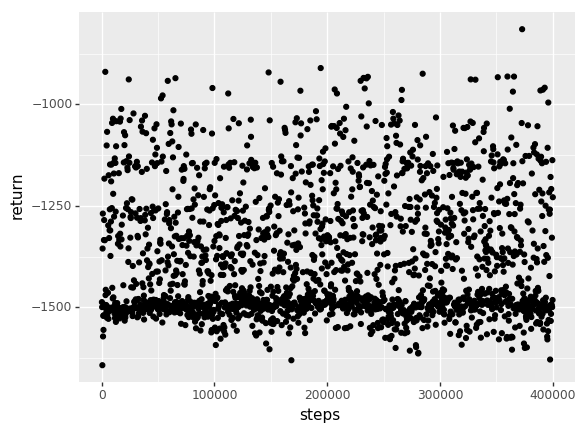

<ggplot: (-9223363269200777016)>

In [22]:
p = (gg.ggplot(results)
     + gg.aes('steps', 'return')
     + gg.geom_point()
    )
p